# Video Games and Consoles - EDA and Hypotheses

# Studying general information

In [1]:
import pandas as pd 
import numpy as np 
import math as mt
df = pd.read_csv('games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


# Preparing the data

### Replace the column names

In [3]:
df.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']

### Convert the data to the required types.

In [4]:
#df.query('year_of_release != year_of_release')
df['year_of_release'].fillna(-1, inplace = True)
df['user_score'].fillna(-1, inplace = True)
df.loc[df['user_score'] == 'tbd', 'user_score'] = -1 

In [5]:
df['year_of_release'] = df['year_of_release'].astype(int)
df['user_score'] = df['user_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int32  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       16715 non-null  float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


There columns that had data types changed were 'year_of_release' and 'user_score'. They were originally 'float64' and 'object' data types respectively, and changed to 'int' and 'float64'. The year was changed to integer because it was unnecessary to have the larger and complex data type. I considered the date_time type to be applied here, but this column is only providing the year, so that could not work. 

The user score was changed to float64 because the row values consisted of non-integer quantifiable values; which the object type could not provide productive information in. 

### Dealing with missing values:

In [6]:
columnsWithNaN = []
columnsWithZero =[]
for x in df.columns:
    if df[df[x].isnull()].empty == False: 
        columnsWithNaN.append(x)
    if 0 in df[x]: 
        columnsWithZero.append(x)
print('NaN:', columnsWithNaN)
print('NaN:', columnsWithZero)

NaN: ['name', 'genre', 'critic_score', 'rating']
NaN: ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']


In [7]:
df['name'].fillna('NULL', inplace = True)
df['genre'].fillna('NULL', inplace = True)
df['critic_score'].fillna(-1, inplace = True)
df['rating'].fillna('NULL', inplace = True)

- For the categorical and identification columns (name, genre, rating), I have replaced missing values with NULL to group NaN values in this term and be excluded in future analysis 
- For quantifiable columns, I have replaced missing values with -1 to avoid quantifiable calculation errors and have an easy grouping to be excluded in future analysis 


- In the 'year_of_release' column, missing rows were modified to '-1'. This seems like an easy item to manually enter so I believe there was a data pulling issue that missed this. 
- In the 'names' and 'genre' columns, there were only two rows that were NaN which also happened to have NaN values for critic_score, user_score, and rating. These rows most likely had a lack of data in general, especially when you see that the game was from 1993 and under an obscere platform.
- In the 'rating' column, there is missing data for 6766 / 16715 rows. Many top games like Super Mario Bros and Pokemon Red are in this query so I imagine there was an automatic data pulling error to get this data. Many less popular entries are also in this area which also could be a victim of data pulling issues or lack of data from the lack of retail success for these. These thought process could also be applied to 'user_score' since they have a similar count of entries.
- Additionally, I have changed the 'tbd' rows to '-1' in the 'user_score' column because there is still no information to assess here. Knowing that there is a score in the works of being generated provides to value to me at the moment, but might be useful in the analysis later. 
- In the 'critic_score' column, there are 8578 missing rows. There are about 2000 more missing rows in this column than 'user_score' which makes sense because you require a professional to provide a critique. I believe there is missing data here from the combination of poor data gathering or lack of popularity to warrent a professional's review. 

### Calculating the total sales (the sum of sales in all regions) for each game and puting these values in a separate column.

In [8]:
def total_region_sales(row):
    totalSales = row['na_sales'] + row['eu_sales'] + row['jp_sales'] + row['other_sales']
    return totalSales
df['total_sales'] = df.apply(total_region_sales, axis = 1)

# Analyzing the data

## Is the data for every period significant?

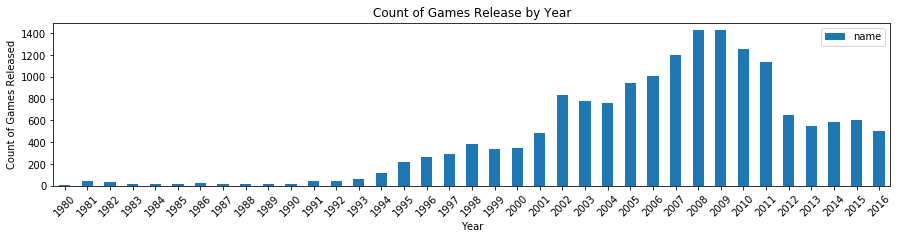

In [9]:
import matplotlib.pyplot as plt
df.query('year_of_release > 0').pivot_table(index = 'year_of_release', values = 'name',aggfunc = 'count'). \
plot(title='Count of Games Release by Year', kind='bar', figsize = (15,3), rot=45); plt.xlabel('Year', fontsize=10);
plt.xticks(rotation=45); plt.ylabel('Count of Games Released', fontsize=10); plt.show()

Many of the older years had very small sales and were dominated by a few consoles such as the GameBoy or NES.
I will identify the cut off of when the data becomes productive and significant as 1993, because that is when we start to see 
the introduction of the PlayStation and Genesis consoles along with a rise of game sales henceforth.

##  Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?

In [10]:
df.pivot_table(index = 'platform', values='total_sales',aggfunc='sum').sort_values('total_sales',ascending = False).head()

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12


The top 3 selling platforms include the PS2, X360, Wii. Below are their distributions.

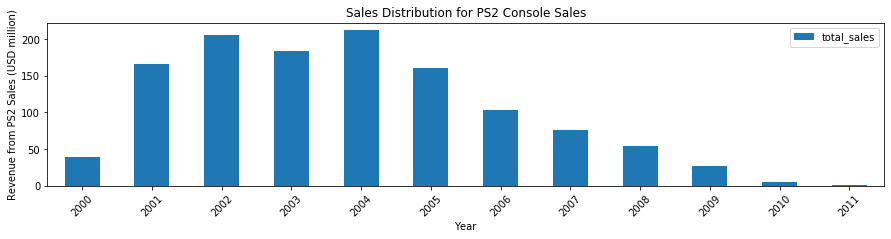

In [11]:
df.query('(platform == "PS2") & (year_of_release > 0)').\
pivot_table(index = 'year_of_release',values='total_sales',aggfunc='sum').\
plot(title='Sales Distribution for PS2 Console Sales',kind='bar',rot=45,figsize=(15,3)); plt.xlabel('Year', fontsize=10);
plt.xticks(rotation=45); plt.ylabel('Revenue from PS2 Sales (USD million)', fontsize=10); plt.show()

This curve is right skewed and does not fit well with any typical distributions. It could be argued that it resembles 
a gamma distribution with a low value for alpha. It is also slightly bi-modal, with the peaks appearing in 2002 and 2004. 
It took about 6 years (2000-2005) for the PS2 to thrive. It took approximately 6 years (2006-2011) for this console to 
fade out.

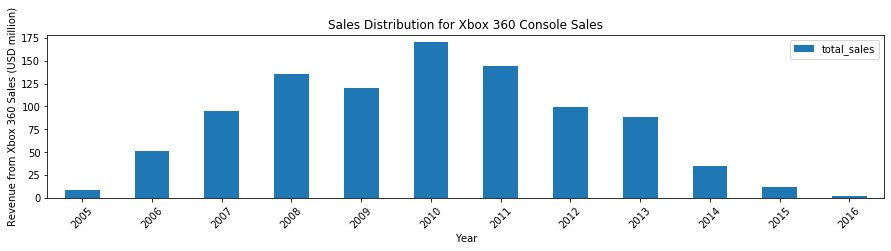

In [12]:
df.query('(platform == "X360") & (year_of_release > 0)').\
pivot_table(index = 'year_of_release',values='total_sales',aggfunc='sum').\
plot(title='Sales Distribution for Xbox 360 Console Sales',kind='bar',rot=45,figsize=(15,3)); plt.xlabel('Year', fontsize=10);
plt.xticks(rotation=45); plt.ylabel('Revenue from Xbox 360 Sales (USD million)', fontsize=10); plt.show()

The curve for sales of Xbox 360 consoles follows the normal distribution relatively well. The peak appears in 2010
and the drops in sales according to each expected standard deviation from the peak. It took 7 years to rise (2005 - 2011).
It took approximately 5 years (2012 - 2016) for the Xbox 360 to fade out, however it is possible that there were more 
sales after 2016 but there was a lack of data.

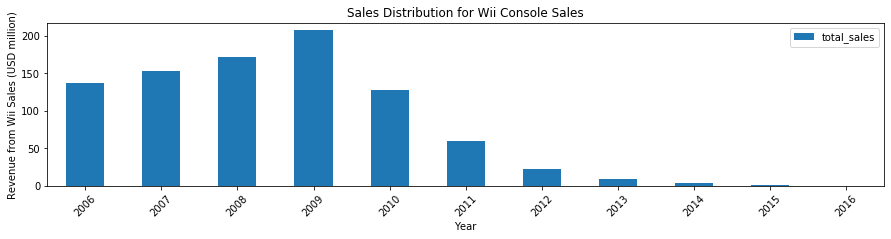

In [13]:
df.query('(platform == "Wii") & (year_of_release > 0)').\
pivot_table(index = 'year_of_release',values='total_sales',aggfunc='sum').\
plot(title='Sales Distribution for Wii Console Sales',kind='bar',rot=45,figsize=(15,3)); plt.xlabel('Year', fontsize=10);
plt.xticks(rotation=45); plt.ylabel('Revenue from Wii Sales (USD million)', fontsize=10); plt.show()

The sales curve for Wii console sales is a very odd distribution that does not follow a typical curve. Sales followed 
a positive correlation from it's debut in 2006 until it's peak in 2009. Afterwards, it experienced a severe drop that continued
to diminish significantly overtime. It took about 5 years for the Wii to rise in sales (2006-2010). It took 
approximately 5 years for the Wii to fade out (2011 - 2015).

##### Section Conclusions 

It appears that all three consoles that were highlighted showed a different distribution in sales, but had similar life times in rise and fall. The average rise in sales were observed to be around 6 years and average fall is observed to be 5.33 years. 

## What data will let me build a prognosis for 2017?

Based on my previous conclusion, I will only be taking the last 6 years of data (2011-2016) to make a forecast for 2017. The reason behind this is so we can observe the entire range of of a platform's rise or fall in a range that would safely capture all this information. For example, if a successful platform was release in 2011, then we would be able have high confidence that we observed it's entire rise in revenue during this period of 6 years based off previous data. On the other side of the coin, if a platform hit it's peak in 2011, then we would be able to observe it's fall in the next 6 years and confirm it's significant decrease in sales over time. 

## Which platforms are leading in sales? Which ones are growing or shrinking? 

In [14]:
df2011 = df.query('year_of_release >= 2011')
df2011['platform'].value_counts()

PS3     708
3DS     512
X360    498
PSV     429
PS4     392
PC      389
PSP     312
XOne    247
Wii     197
DS      184
WiiU    147
PS2       7
Name: platform, dtype: int64

I've made an assumption that the top three platforms are the ones going through it's peak and then it's fall during this 6 year period because the general ~6 year or ~6 year fall is expected. As these products begin to die out, the next generation of consoles will be seen to rise in sales.

##### Shrinking Platforms

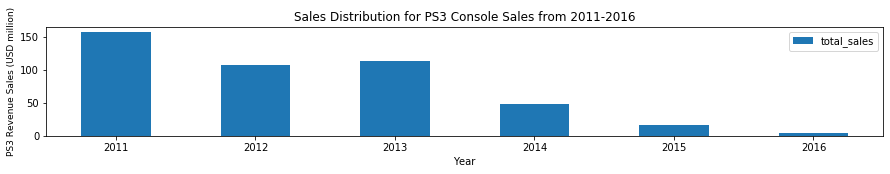

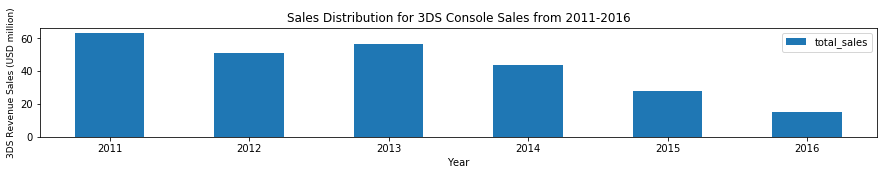

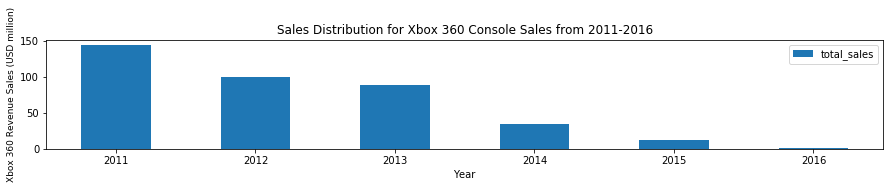

In [15]:
df2011.query('platform == "PS3"').\
pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').\
plot(title='Sales Distribution for PS3 Console Sales from 2011-2016',kind='bar',rot=0,figsize=(15,2))
plt.xlabel('Year', fontsize=10); plt.ylabel('PS3 Revenue Sales (USD million)', fontsize=9); plt.show()

df2011.query('platform == "3DS"').\
pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').\
plot(title='Sales Distribution for 3DS Console Sales from 2011-2016',kind='bar',rot=0,figsize=(15,2))
plt.xlabel('Year', fontsize=10); plt.ylabel('3DS Revenue Sales (USD million)', fontsize=9); plt.show()

df2011.query('platform == "X360"').\
pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').\
plot(title='Sales Distribution for Xbox 360 Console Sales from 2011-2016',kind='bar',rot=0,figsize=(15,2))
plt.xlabel('Year', fontsize=10); plt.ylabel('Xbox 360 Revenue Sales (USD million)', fontsize=9); plt.show()

##### PS3
From this period, we can see a great fall from over $ 100 million in sales to a fraction of what it once was in 
about 6 years for PS3 console sales.

##### 3DS
The Nintendo 3DS had less of a harsh fall from the revenue it generated in 2011, but it comparison, it never had 
such generated such a large revenue compared to some other consoles during this time period. This is seen with the peak
at around  60 mil when the PS3 and Xbox 360 had over $ 100 mil in 2011.

##### Xbox 360
The curve of this distribution is very similar to the PS3 curve where the great success it saw in 2011 of over 
$100 mil came to a sharp crash over this period to nearly no sales in 2016.'

##### Growing Platforms

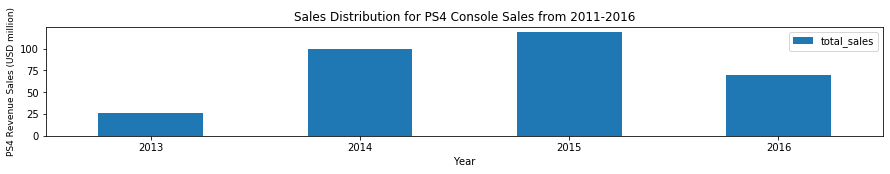

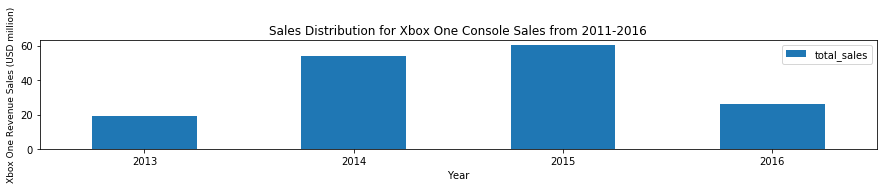

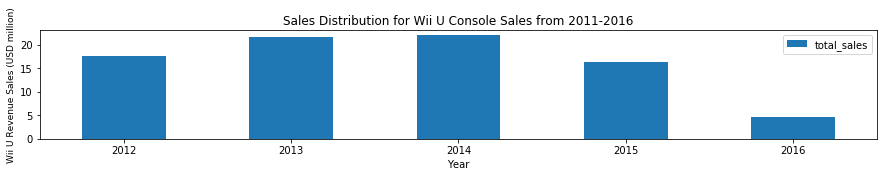

In [16]:
df2011.query('platform == "PS4"').\
pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').\
plot(title='Sales Distribution for PS4 Console Sales from 2011-2016',kind='bar',rot=0,figsize=(15,2))
plt.xlabel('Year', fontsize=10); plt.ylabel('PS4 Revenue Sales (USD million)', fontsize=9); plt.show()

df2011.query('platform == "XOne"').\
pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').\
plot(title='Sales Distribution for Xbox One Console Sales from 2011-2016',kind='bar',rot=0,figsize=(15,2))
plt.xlabel('Year', fontsize=10); plt.ylabel('Xbox One Revenue Sales (USD million)', fontsize=9); plt.show()

df2011.query('platform == "WiiU"').\
pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').\
plot(title='Sales Distribution for Wii U Console Sales from 2011-2016',kind='bar',rot=0,figsize=(15,2))
plt.xlabel('Year', fontsize=10); plt.ylabel('Wii U Revenue Sales (USD million)', fontsize=9); plt.show()

##### PS4
As we witness one generation of consoles evolve into the next era of gaming, we see the old tech die out and new 
ones rise. We see a rise in sales from the console"s debut in 2013 up to 2015 where it received over $ 100 mil in sales. 
Surprisngly, 2016 saw a fall in sales compared to the rise in 2015. Honestly, I believe there is a lack of 2016 because 
this issue is seen for the Xbox One as well, and also from my knowledge of how well the console is selling today.

##### Xbox One
While also witnessing a positive trend in sales figures from it's debut in 2013, the number of consoles sold is not 
as high as the success of the PS4. From what I know, the marketing and game exclusitivity on the PS4 helped propel it to win
this generation of console wars. Nonetheless, the rise in sales over this period is a welcome one. The fall in 2016 is also
a victim of what I believe is lack of data.

##### Wii U 
The WiiU saw a poor rise of only 3 years compared to the previously observed 6 years. I want to say that this 
console will continue to see success in 2017, but it's fall after 2014 says otherwise. This is a short lived console, but
did see some rise during this period; even if it was a very small revenue compared to the PS4 and Xbox One

##### Section Conclusion

The PS3, 3DS, and Xbox 360 all saw a fairly positive rise before 2011, but are now witnessing a shrinking sales count during the observed period of 2011-2016. The next generation of consoles (PS4, Xbox 360, and Wii U) are now taking the spotlight to see a rise during this observed period. The Wii U had a very shortlived rise of 3 years compared to the aforementioned 6 year rise of older more successful consoles. I believe the PS4 and Xbox One can be stronger contenders in 2017 as profitable consoles, especially with my hunch that the data is not completely accurate for 2016. 

## Are the differences in sales for global sales of all games divided by platform significant? What about average sales on various platforms? 

#### Global Sales All Games 

In [17]:
import seaborn as sns
grouped2011 = df2011.pivot_table(index=['platform','year_of_release'],values='total_sales',aggfunc='sum')
grouped2011.reset_index(inplace=True)
grouped2011.head(6)

,platform,year_of_release,total_sales
0,3DS,2011,63.20
1,3DS,2012,51.36
2,3DS,2013,56.57
3,3DS,2014,43.76
4,3DS,2015,27.78
5,3DS,2016,15.14


Text(0.5, 1.0, 'Yearly Total Game Sales for Consoles from 2011-2016')

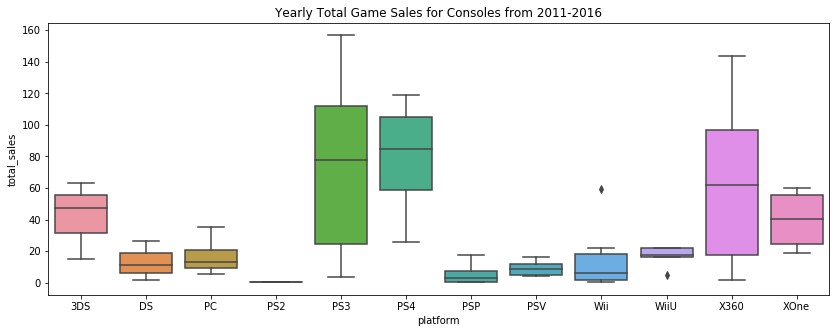

In [18]:
plt.figure(figsize = (14,5))
sns.boxplot(x='platform', y= 'total_sales', data = grouped2011).set_title("Yearly Total Game Sales for Consoles from 2011-2016")

While it only debutted in 2013, the PS4 has consistently sold well from the time period we are observing. This is definitely because it's experiencing it's rise in popularity while most other platforms during this period are observing their shrinkage. Surprsingly, the PS3's total sales median is close to the PS4 which shows it's downfall was a slow one that still saw success even with large variance. The next two highest platforms are the Xbox 360 and the 3DS which are relatively significantly successful from the rest of the platforms within this range. All the other platforms below the X360 and 3DS are experiencing a harsh fall or slow rise (e.g. XOne).

##### Average Sales for Platforms

In [19]:
test2011 = df2011.pivot_table(index=['platform','year_of_release'],values='total_sales',aggfunc='mean')
test2011.reset_index(inplace=True)
test2011.head(6)

,platform,year_of_release,total_sales
0,3DS,2011,0.544828
1,3DS,2012,0.552258
2,3DS,2013,0.621648
3,3DS,2014,0.547000
4,3DS,2015,0.323023
5,3DS,2016,0.329130


Text(0.5, 1.0, 'Yearly Average Game Sales for Consoles from 2011-2016')

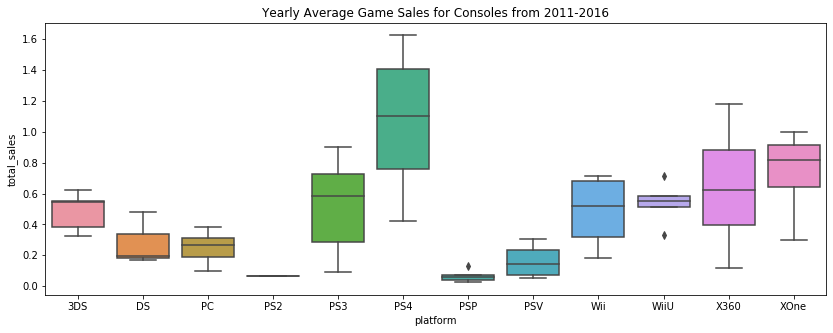

In [20]:
plt.figure(figsize = (14,5))
sns.boxplot(x='platform', y= 'total_sales', data = test2011).set_title("Yearly Average Game Sales for Consoles from 2011-2016")

When looking at average yearly sales instead of total cumulated sales from 2011-2016, PS4 is the clear winner here. This is definitely because the PS4 saw excellent growth from when it first debutted back in 2013. The second highest yearly average is the Xbox One which also makes sense because it is a new console in this generation, meaning that it is also in it's growth stage. These products should have strong average sales because they are approaching the peak. The respective previous generation consoles, the PS3 and Xbox 360, also see relative success which represents the slow downfall within this observed period. It is surprising to see them perform better than the 3DS and Wii U so well since they are also relatively new consoles as well.

##### Section Analysis 
When looking at only global sales, it seems like the platform with the greatest medians are older Nintendo consoles such as the NES and Gameboy. Nintendo products would take 4/5 of the greatest median sales in USD. In the 6th spot comes the Xbox 360, which is a more recent console first appearing in 2011. This would mean that Nintendo's marketshare would finally be challenged decades later after their reign in sales found all over the world. 


When it comes to looking at different regions and their sales on various platforms, there is a significant difference. It is common for older platforms from Nintendo to have a higher median and quartiles of games sold to perform well in Japan compared to NA and EU such as the NES, Gameboy, and SNES. Surprsingly, even though Playstation is also from Japan, we saw that it faired even better outside of it's origin country. This is seen in the original Playstation all the way to the recent PS4. When a console outside of Japan is created, it seems to only perform well in NA and EU. This is seen for all of the XBox series, the ancient Atari 2600, and even PC games. 

## How do user and professional reviews affect sales for the Wii?

#### Will be look at the Wii because it is a console that I owned

In [21]:
df_wii_critic = df.query('(platform == "Wii") & (critic_score > 0) & (total_sales < 15)')
df_wii_user = df.query('(platform == "Wii") & (user_score > 0) & (total_sales < 15)')
df_wii_user['user_score'] = df_wii_user['user_score']*10 
print('Multiplied user_score values to match the same base as critic score ')

Multiplied user_score values to match the same base as critic score 


C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


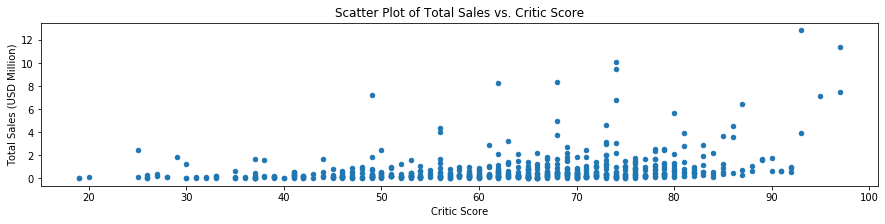

Correlation between sales and critic score: 0.29932951874441294



In [22]:
df_wii_critic.plot(title='Scatter Plot of Total Sales vs. Critic Score', 
                   x='critic_score',y='total_sales',kind='scatter', figsize=(15,3))
plt.xlabel('Critic Score', fontsize=10); plt.ylabel('Total Sales (USD Million)', fontsize=10); plt.show()
print('Correlation between sales and critic score:',df_wii_critic['critic_score'].corr(df_wii_critic['total_sales'])); print()

There is a very slight positive correlation of 0.3 between total sales and critic scores. This means you can expect
a slight increase in sales when the game has a higher critic score, and vice versa. This makes sense since a professional 
reviewer has stronger influence on consumer habits and marketing to make a game be preceived better, which entices others
to purchase more copies of the game. It seems it is not high enough to make many people change their opinion however.
There is a good chance a good game will already get many sales with or without a high critic score.

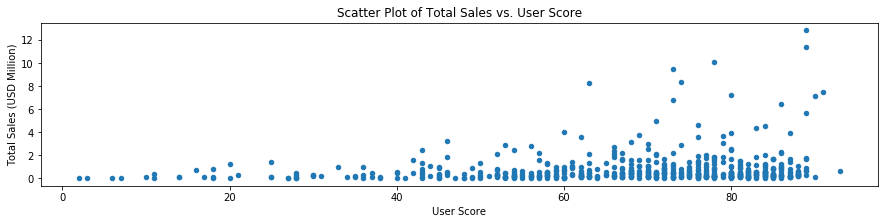

Correlation between sales and user score: 0.17719985019434015



In [23]:
df_wii_user.plot(title='Scatter Plot of Total Sales vs. User Score', 
                 x='user_score',y='total_sales',kind='scatter', figsize=(15,3))
plt.xlabel('User Score', fontsize=10); plt.ylabel('Total Sales (USD Million)', fontsize=10); plt.show()
print('Correlation between sales and user score:',df_wii_user['user_score'].corr(df_wii_user['total_sales'])); print()

There is a very small positive correlation of 0.17 between total sales and user scores. This means you can barely 
expect a small increase in sales when the game has a higher user score, and vice versa. It seems that people can have more
varying opinions on games and not influence the purchases of others compared to a professional reviewer who has a keen eye
on what makes a good game and their stronger marketing opinion.

## How do sales of the same game compare to their other platform counterparts? 

In [24]:
df.query('year_of_release > 2006').pivot_table(index='name',values='platform',aggfunc='count').\
sort_values('platform',ascending=False).head(7)

,platform
name,
Ratatouille,9
FIFA 14,9
LEGO Marvel Super Heroes,9
Madden NFL 08,8
Terraria,8
LEGO Jurassic World,8
FIFA 15,8


I queried games that had the highest count of platforms it was ported to. I only considered games that were released after 2006 because that was when the Wii was released. The names were stored into a list. 

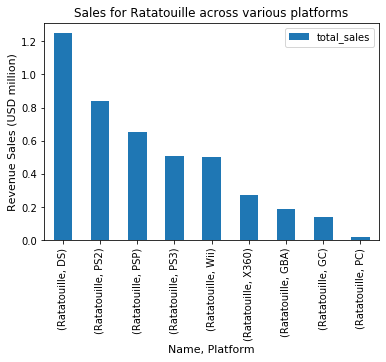

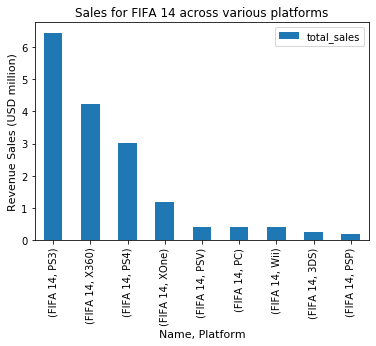

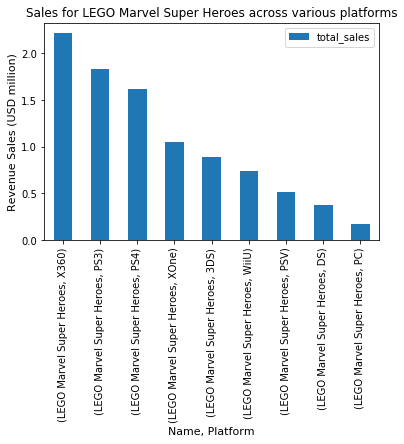

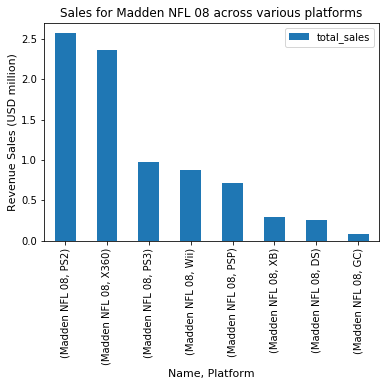

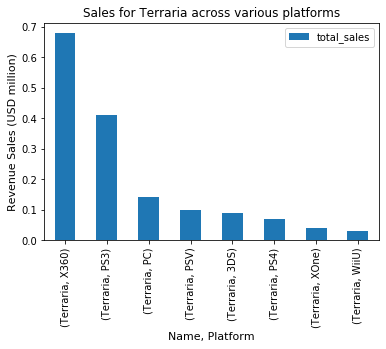

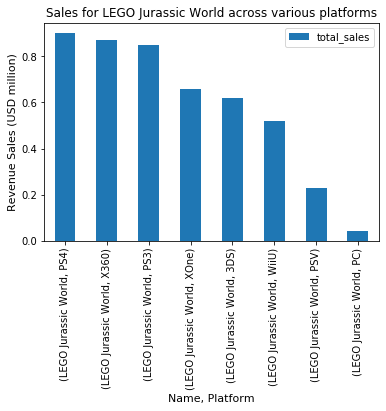

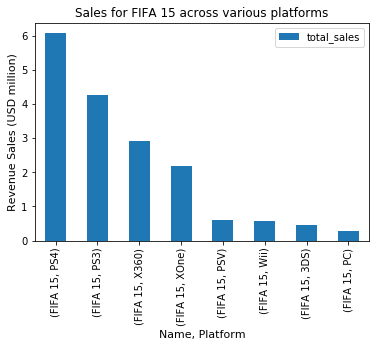

In [25]:
df_multi = ['Ratatouille','FIFA 14','LEGO Marvel Super Heroes','Madden NFL 08','Terraria','LEGO Jurassic World','FIFA 15']
for x in df_multi:
    (df[df['name'] == x].pivot_table(index=['name','platform'],values='total_sales')
    .sort_values('total_sales',ascending=False)
    .plot(kind='bar',rot=90))
    plt.xlabel('Name, Platform', fontsize=11)
    plt.ylabel('Revenue Sales (USD million)', fontsize=11)
    plt.title('Sales for {} across various platforms'.format(x))
    plt.show()

Looking at these different games, the highest selling platforms among these diverse games were Xbox 360 and PS3. They frequently appeared in the top 3 best selling platforms for the games. Some other games appear have high success with the newest generation consoles such as PS4 which means that there is profitability potential for games on new consoles for 2017. A common worst selling platform among the 7 games here is definitely the PC platform. Some other uncommon platforms appear here as well with WiiU, PSP, and Game Cube. 

## What is the typical distribution of games by genre and which ones are the most profitable?

In [26]:
#df.pivot_table(index='genre',values=['total_sales'],aggfunc=['sum','count']).sort_values('total_sales',ascending=False)
#How do I sort when I have multiple aggfunc items? It is giving me duplicate issues because the columns are listed as 
# sum total_sales and count total_sales 

df.pivot_table(index='genre',values=['total_sales'],aggfunc='sum').sort_values('total_sales',ascending=False)

,total_sales
genre,
Action,1744.17
Sports,1331.27
Shooter,1052.45
Role-Playing,934.56
Platform,827.77
Misc,802.51
Racing,728.67
Fighting,447.53
Simulation,389.97


The top 3 most profitable genres of all the data are Action, Sports, and Shooter games. These are very eye catching genres that entice a large audience of people. The revenue difference between these top three are about 300 USD million which is pretty significant. The differences after the top 3 genres have a smaller difference of about $100 million. The top 3 least profitable genres are Puzzle, Adventure, and Strategy. I under why puzzle and strategy games are more difficult to generate revenue from the high learning curve and stress from the games. 

# Creating a user profile for each region

For each region (NA, EU, JP), I will determine:
- The top five platforms.
- The top five genres. 
- Do ESRB ratings affect sales?

### NA User Profile

#### NA - Top 5 Platforms

Text(0.5, 1.0, 'Median Game Sales based on Top 5 Platforms in NA')

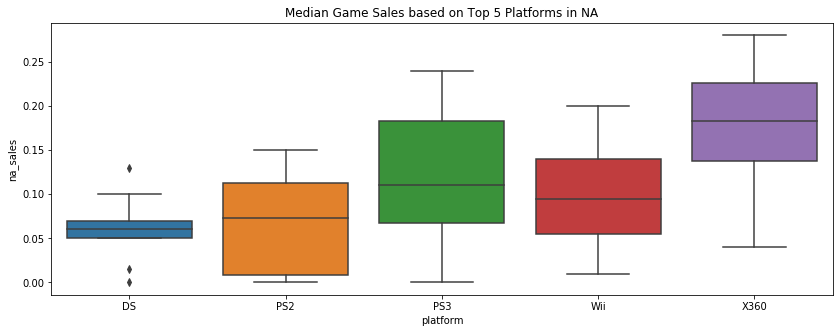

In [27]:
top5_na = df.pivot_table(index='platform',values='na_sales',aggfunc='sum').sort_values('na_sales',ascending=False).head()
top5_na_list = top5_na.index.to_list()

df_region = df[df['platform'].isin(top5_na_list)]
df_region = df_region.query('year_of_release > 1985').pivot_table(index=['platform','year_of_release'],values='na_sales',aggfunc='median')
df_region.reset_index(inplace=True)

plt.figure(figsize = (14,5))
sns.boxplot(x=df_region['platform'], y= 'na_sales', data = df_region).set_title("Median Game Sales based on Top 5 Platforms in NA")

In NA, the console that has the highest median in terms of sales is the Xbox 360 which makes sense because it is an American made console. The marketshare for the Xbox 360 is mucher higher in NA compared to EU or JP. The other 4/5 consoles are split between Nintendo and Playstation. Surprisingly, the market share for the other 4 consoles are still smaller in other countries even though they were originated from Japan. This just shows how successful the general consumer market is in NA.

#### NA - Top 5 Genres

(0, 1.5)

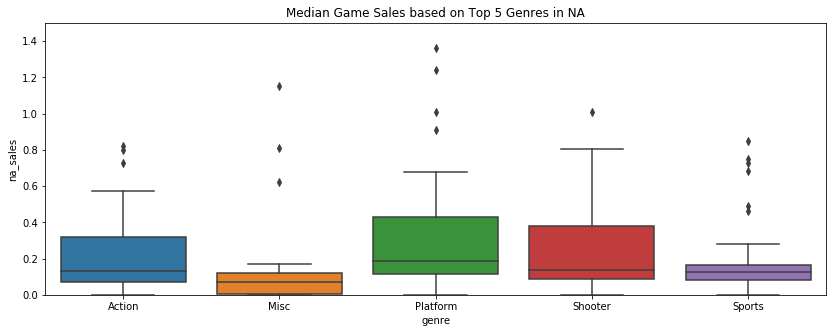

In [28]:
top5_na = df.pivot_table(index='genre',values='na_sales',aggfunc='sum').sort_values('na_sales',ascending=False).head()
top5_na_list = top5_na.index.to_list()

df_region = df[df['genre'].isin(top5_na_list)]
df_region = df_region.query('year_of_release > 0').pivot_table(index=['genre',
                                                                      'year_of_release'],values='na_sales',aggfunc='median')
df_region.reset_index(inplace=True)

plt.figure(figsize = (14,5))
sns.boxplot(x=df_region['genre'], y= 'na_sales', data = df_region).set_title("Median Game Sales based on Top 5 Genres in NA")
plt.ylim(0, 1.5)

In NA, the genre that has the highest sales is Platform. Not far behind are the Shooter and Action genres. It seems like the rest of the world is not as interested in these game genres or does not have enough buying powering to make these kind of purchases in first place. Japan especially has smaller medians than the medians of the high performing genres in NA. 

#### NA - ESRB Rating

(0, 1.5)

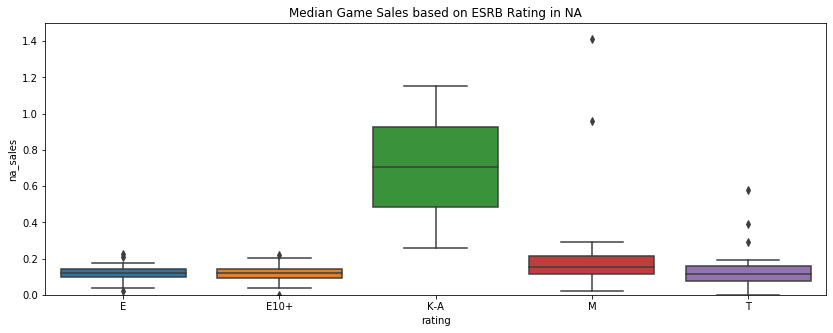

In [29]:
top5_na = df.query('~(rating == "NULL")').\
    pivot_table(index='rating',values='na_sales',aggfunc='sum').sort_values('na_sales',ascending=False).head()
top5_na_list = top5_na.index.to_list()

df_region = df[df['rating'].isin(top5_na_list)]
df_region = df_region.query('year_of_release > 0').pivot_table(index=['rating',
                                                                      'year_of_release'],values='na_sales',aggfunc='median')
df_region.reset_index(inplace=True)

plt.figure(figsize = (14,5))
sns.boxplot(x=df_region['rating'], y= 'na_sales', data = df_region).set_title("Median Game Sales based on ESRB Rating in NA")
plt.ylim(0,1.5)

Surprisingly, one of the highest selling ESRB rating games are Mature. The NA market are a lot of adults with disposable incomes that allow them to make these purchases from what I see. EU also has a relatively high median in sales for mature games as well. It seems like there is a lot more data and sales for NA overall which inflates these numbers. These plots look like Japan is not interested in many games, but they having a smaller population to make these purchases as well.

I also wanted to highlight how the K-A rating has a small entry count which makes it prone to skewing as seen in the box plot as well. 

### EU User Profile

#### EU - Top 5 Platforms

Text(0.5, 1.0, 'Median Game Sales based on Top 5 Platforms in EU')

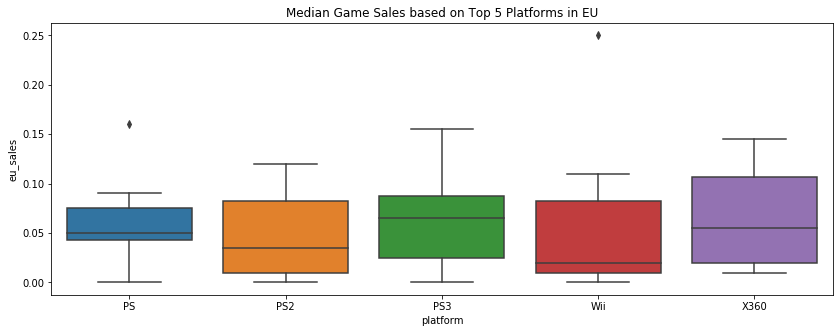

In [30]:
top5_eu = df.pivot_table(index='platform',values='eu_sales',aggfunc='sum').sort_values('eu_sales',ascending=False).head()
top5_eu_list = top5_eu.index.to_list()

df_region = df[df['platform'].isin(top5_eu_list)]
df_region = df_region.query('year_of_release > 0').pivot_table(index=['platform',
                                                                      'year_of_release'],values='eu_sales',aggfunc='median')
df_region.reset_index(inplace=True)

plt.figure(figsize = (14,5))
sns.boxplot(x=df_region['platform'],y= 'eu_sales',data=df_region).set_title("Median Game Sales based on Top 5 Platforms in EU")

Compared to NA, the EU population does not purchase as many games as seen from the smaller values on the y-axis. Their highest selling platform is the PS3 which also faired well in NA and JP. All of these high performing consoles in EU are almost all the same as NA except the DS was replaced by the PS here. This could mean that these market are very similar and will act as a mirror image for success in one area. 

#### EU - Top 5 Genres

(0, 0.4)

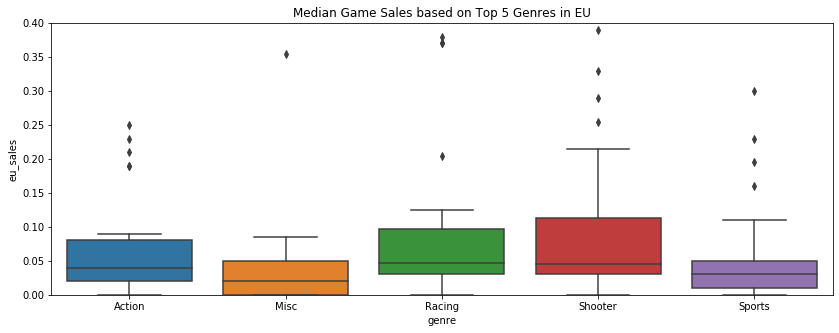

In [31]:
top5_eu = df.pivot_table(index='genre',values='eu_sales',aggfunc='sum').sort_values('eu_sales',ascending=False).head()
top5_eu_list = top5_eu.index.to_list()

df_region = df[df['genre'].isin(top5_eu_list)]
df_region = df_region.query('year_of_release > 0').pivot_table(index=['genre',
                                                                      'year_of_release'],values='eu_sales',aggfunc='median')
df_region.reset_index(inplace=True)

plt.figure(figsize = (14,5))
sns.boxplot(x=df_region['genre'], y= 'eu_sales', data = df_region).set_title("Median Game Sales based on Top 5 Genres in EU")
plt.ylim(0,0.4)

The best performing genre in EU is shooter which had also performed well NA. The shared success is also seen for Action and Sports. Again, it appears that Japan has less sales success for these games, but normalization of buying power and population should be considered as well. The only difference from the NA list of games is that Platform was replaced by Racing for EU. 

Something surprising here is that I'm pretty sure the Platform genre should be in this boxplot. The way I generated my list of top 5 genres was creating a list that had the highest sales sums. The platform genre for EU did not make this high summed list. The boxplots however visualize medians and not total sums, and I'm positive that platform games in EU had a relatively high median. This just means that while platform games perform well in EU, not many were introduced to EU in first place. This is odd and I believe more platform games can be presented in EU. 

#### EU - ESRB Ratings

(0, 0.8)

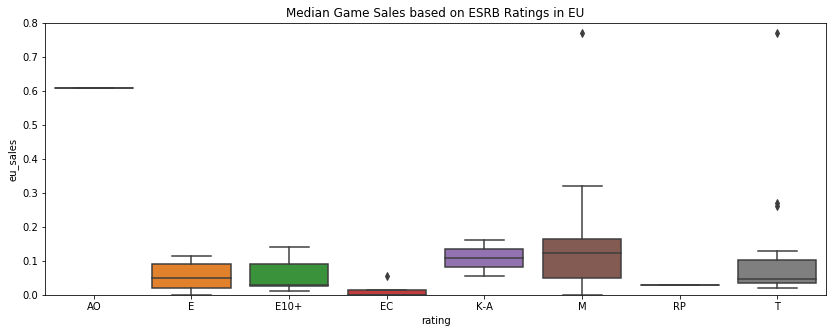

In [32]:
top5_eu = df.query('~(rating == "NULL")').pivot_table(index='rating',values='eu_sales',aggfunc='sum').sort_values('eu_sales',ascending=False)
top5_eu_list = top5_eu.index.to_list()

df_region = df[df['rating'].isin(top5_eu_list)]
df_region = df_region.query('year_of_release > 0').pivot_table(index=['rating',
                                                                      'year_of_release'],values='eu_sales',aggfunc='median')
df_region.reset_index(inplace=True)

plt.figure(figsize = (14,5))
sns.boxplot(x=df_region['rating'], y= 'eu_sales', data = df_region).set_title("Median Game Sales based on ESRB Ratings in EU")
plt.ylim(0,0.8)

The first odd thing to mention is how the AO rating has an extremely low entry count, which is forcing the median to be extremely high. Apparently NA has not sold any of these games and JP has not seen success in this genre. Besides AO, mature is again the highest performer in terms of games. The other ratings are all similar in range and follow a similar trend to the NA market. I believe ratings such as Everyone receive many entries which do not perform extremely well, which forces the median to go down. 

### Japan User Profile

#### JP - Top 5 Platforms

(0, 0.5)

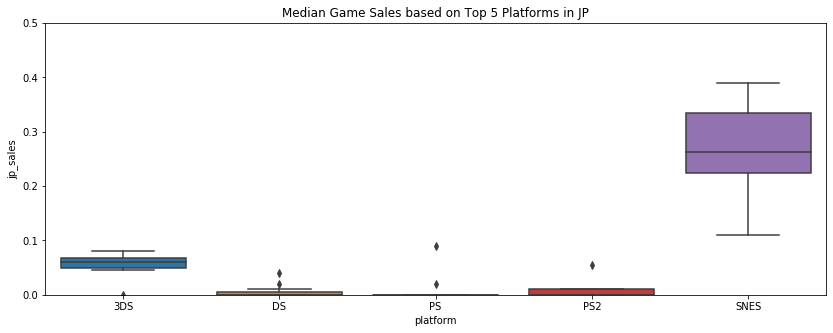

In [33]:
top5_jp = df.pivot_table(index='platform',values='jp_sales',aggfunc='sum').sort_values('jp_sales',ascending=False).head()
top5_jp_list = top5_jp.index.to_list()

df_region = df[df['platform'].isin(top5_jp_list)]
df_region = df_region.query('year_of_release > 0').pivot_table(index=['platform',
                                                                      'year_of_release'],values='jp_sales',aggfunc='median')
df_region.reset_index(inplace=True)

plt.figure(figsize = (14,5))
sns.boxplot(x=df_region['platform'],y='jp_sales',data =df_region).set_title("Median Game Sales based on Top 5 Platforms in JP")
plt.ylim(0,.5)

The SNES dominated the JP market and did not see much success in NA or EU. The second highest performing platform was the 3DS which also saw isolated success in JP. The rest of the platforms here performed well in JP, but had significantly higher median sales in EU and especially NA.

It was at this point when I realized that there were a significant number of 0 sales for many popular games when that is not the case. 

#### JP - Top 5 Genres

(0, 0.6)

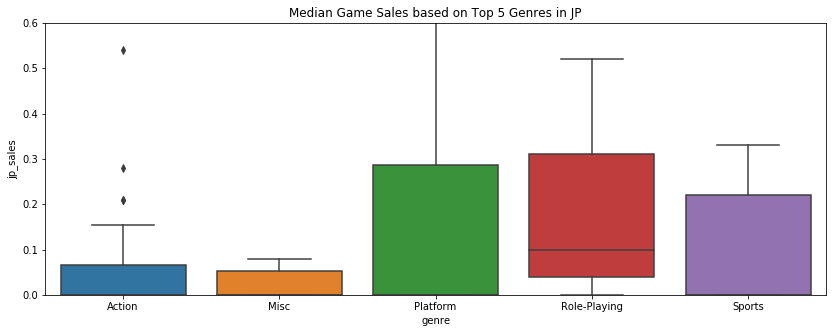

In [34]:
top5_jp = df.pivot_table(index='genre',values='jp_sales',aggfunc='sum').sort_values('jp_sales',ascending=False).head()
top5_jp_list = top5_jp.index.to_list()

df_region = df[df['genre'].isin(top5_jp_list)]
df_region = df_region.query('year_of_release > 0').pivot_table(index=['genre',
                                                                      'year_of_release'],values='jp_sales',aggfunc='median')
df_region.reset_index(inplace=True)

plt.figure(figsize = (14,5))
sns.boxplot(x=df_region['genre'], y= 'jp_sales', data = df_region).set_title("Median Game Sales based on Top 5 Genres in JP")
plt.ylim(0,0.6)

The best performing game by a long shot in JP is role-playing games. The rest of the game genres were overshadowed by the success seen in Na and EU. And the median value being zero for many of these genres, probably because many were not translated in to Japanese. 

#### JP - ESRB Ratings

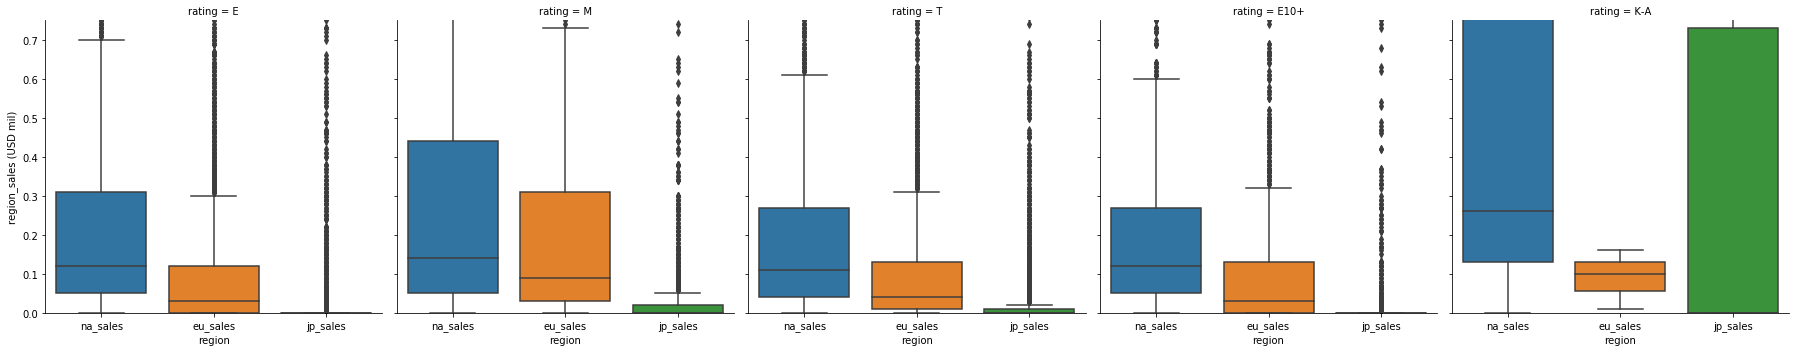

In [35]:
top5_jp = df.query('~(rating == "NULL")').pivot_table(index='rating',values='jp_sales',aggfunc='sum')\
.sort_values('jp_sales',ascending=False).head()

regions = ["na_sales", "eu_sales", "jp_sales"]
df_region_sale = pd.melt(df, ["name", "platform", "genre", "rating"], regions, "region", "region_sales (USD mil)")
df_region_sale = df_region_sale[df_region_sale['rating'].isin(top5_jp.index)]

plot = sns.catplot(kind="box",data=df_region_sale,col="rating",x="region",y="region_sales (USD mil)",col_wrap=5)
plt.ylim(0, .75)
plt.show()

Text(0.5, 1.0, 'Total Game Sales based on ESRB Rating in JP')

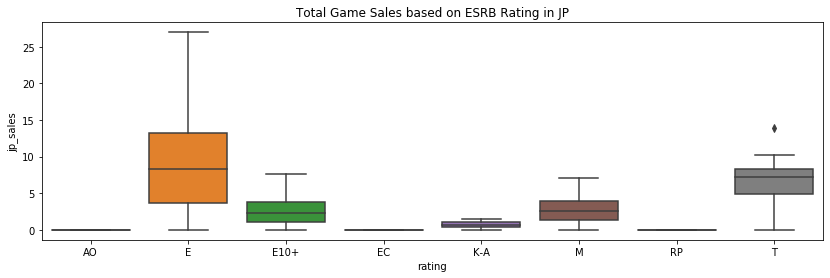

In [36]:
top5_jp = df.query('~(rating == "NULL")').pivot_table(index='rating',values='jp_sales',aggfunc='sum').sort_values('jp_sales',ascending=False)
top5_jp_list = top5_jp.index.to_list()

df_region = df[df['rating'].isin(top5_jp_list)]
df_region = df_region.query('year_of_release > 0').pivot_table(index=['rating',
                                                                      'year_of_release'],values='jp_sales',aggfunc='sum')
df_region.reset_index(inplace=True)

plt.figure(figsize = (14,4))
sns.boxplot(x=df_region['rating'], y= 'jp_sales', data = df_region).set_title("Total Game Sales based on ESRB Rating in JP")
#plt.ylim(0,0.1)

While the median sales for all these ratings were zero, we do see that the K-A rating have performed fairly well with 0.7 million in sales for the third quartile. But this rating has a low number of entries which could skew these numbers. Compared to the other regions, they get demolished by the sales of EU and NA.

I have changed this boxplot to include the SUM of sales instead of median sales. The median sales boxplot was not providing very productive information because a majority of the ratings were appearing as 0. The total sales shows that the E for everyone rating has cumulated the highest number of sales, which shows that JP is most open to this maturity level. The second best performing rating is the Teen genre which also has a smaller variance. 

# Hypothesis testing:


### Average user ratings of the Xbox One and PC platforms are the same.

H0: The averages user rating for the Xbox One and PC platforms are equal to each other

H1: The averages user rating for the Xbox One and PC platforms are NOT equal to each other

In [38]:
from scipy import stats as st
xone_rating = df.query('platform == "XOne"').drop(df.columns.difference(['user_score']),1)
pc_rating = df.query('platform == "PC"').drop(df.columns.difference(['user_score']),1)
alpha = .05 #using 95% critical value because that's academically standard 
results = st.ttest_ind(xone_rating, pc_rating)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("""We reject the null hypothesis: The p-value is less than the critical value (0.05), thus there 
        is sufficient evidence to conclude that the average user rating for XBox One and PC games are NOT same.""")
else:
        print("""We can't reject the null hypothesis""")

p-value:  [0.00102598]
We reject the null hypothesis: The p-value is less than the critical value (0.05), thus there 
        is sufficient evidence to conclude that the average user rating for XBox One and PC games are NOT same.


The p-value tells us that there is a probability of 0.1% of getting the same average user rating for both XBox One
and PC which is extreme!

### Average user ratings for the Action and Sports genres are different.

H0: The averages user rating for the Action and Sports genres are equal to each other

H1: The averages user rating for the Action and Sports genres are NOT equal to each other

In [39]:
from scipy import stats as st

print()

action_rating = df.query('genre == "Action"').drop(df.columns.difference(['user_score']),1)
sports_rating = df.query('genre == "Sports"').drop(df.columns.difference(['user_score']),1)
alpha = .05 #using 95% critical value because that's academically standard 
results = st.ttest_ind(action_rating, sports_rating)

print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("""We reject the null hypothesis: The p-value is less than the critical value (0.05), thus there 
        is sufficient evidence to conclude that the average user rating for Action and Sports game genres are NOT same.""")
else:
        print("""We can't reject the null hypothesis""")


p-value:  [1.20255684e-08]
We reject the null hypothesis: The p-value is less than the critical value (0.05), thus there 
        is sufficient evidence to conclude that the average user rating for Action and Sports game genres are NOT same.


The p-value tells us that there is a EXTREMELY small probability of getting the same average user rating for 
both Action and Sports genre games. With this data set, they practically should never have the same average user rating!

# General conclusion

Based on this data, we have identified areas to generate high revenue for 2017.

If we want to make a high quality console, we can expect it to rise in sales and reach it's peak within 6 years. And also become absolutely obsolete within 6 years as well. Recent data does show that consoles are rising and dying sooner which shows the customers have an evolving demand. It might be a good idea to sell the next generation console sooner. 

If we were to make an investment in a console, it seems that the Playstation series has consistent success with it's variety of products in many regions. The recent Nintendo products have not performed as well as the Wii did back in 2007 so it does not seem like a safe investment at the momment. 

When it comes to region, we should definitely focus in the NA market since they have significantly higher selling power compared to EU and JP. That doesn't mean transactions should be cancelled in that area, but it means that heavier marketing and greater analysis should be applied to NA. 

In terms of genre, we should look at games in the Platform, Shooter, and Action genres. These games have generated high success within the NA and EU region, which is great o


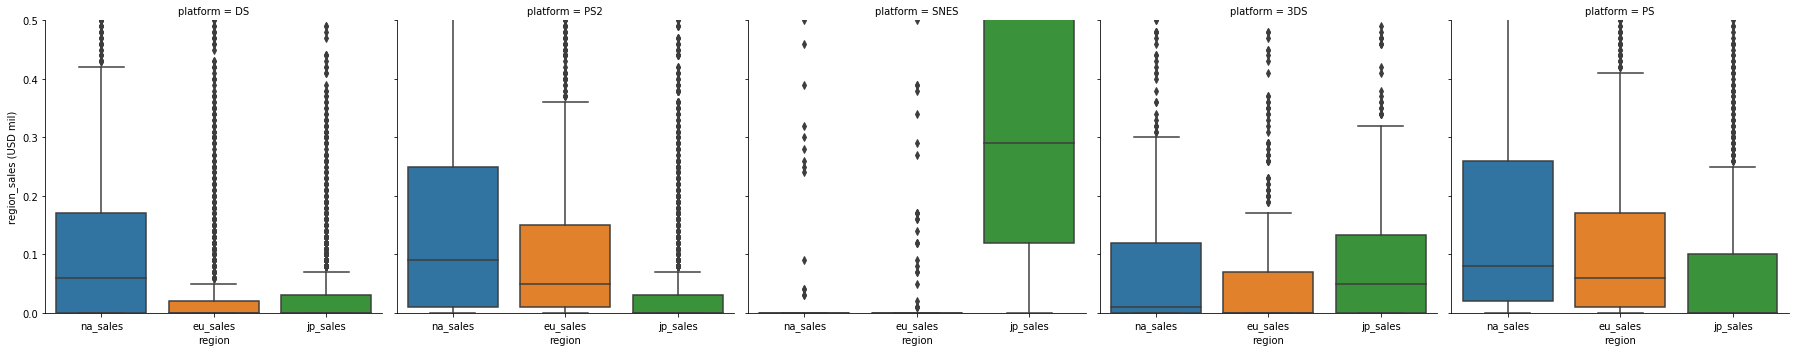

In [40]:
#unused code
# old removed code 
top5_jp = df.pivot_table(index='platform',values='jp_sales',aggfunc='sum').sort_values('jp_sales',ascending=False).head()
regions = ["na_sales", "eu_sales", "jp_sales"]
df_region_sale = pd.melt(df, ["name", "platform", "genre", "rating"], regions, "region", "region_sales (USD mil)")
df_region_sale = df_region_sale[df_region_sale['platform'].isin(top5_jp.index)]
plot = sns.catplot(kind="box",data=df_region_sale,col="platform",x="region",y="region_sales (USD mil)",col_wrap=5,)
plt.ylim(0, .5)
plt.show()